# Bayesian Neural Network in PyMC3
(c) 2016 by Thomas Wiecki

In [1]:
import sys, os
# sys.path.insert(0, '/Users/taku-y/git/github/pymc-devs/pymc3/')

%matplotlib inline
import pymc3 as pm
import theano.tensor as T
import theano
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons, make_circles, make_classification
import seaborn as sns

/Users/fonnescj/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
import theano
theano.__version__

'0.8.2'

In [3]:
pm.__version__

'3.0'

In [4]:
theano.config.floatX

'float64'

In [5]:
#X, Y = datasets.make_blobs(n_samples=200, n_features=2, centers=2, cluster_std=3.0, 
#                           center_box=(-5.0, 5.0), shuffle=True, random_state=None)

X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

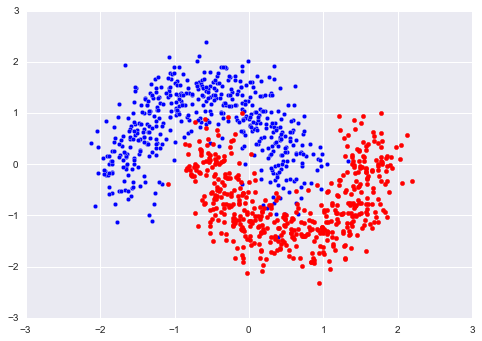

In [6]:
plt.scatter(X[Y==0, 0], X[Y==0, 1])
plt.scatter(X[Y==1, 0], X[Y==1, 1], color='r')

In [7]:
def Ordered(name, var, model=None):
    order = T.constant(list(range(var.tag.test_value.shape[1])))
    return pm.Potential(
        name,
        T.switch(T.eq(T.argsort(T.sum(var, axis=0)), order), 0, -np.inf),
        model=model
    )

In [8]:
# Turn inputs and outputs into shared variables so that we can change them later
ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)

n_hidden = 5

with pm.Model() as neural_network:
    # Below we require an ordering of the summed weights, thus initialize in this order
    init_1 = np.random.randn(X.shape[1], n_hidden)
    init_1 = init_1[:, np.argsort(init_1.sum(axis=0))]
    init_2 = np.random.randn(n_hidden, n_hidden)
    init_2 = init_2[:, np.argsort(init_2.sum(axis=0))]
    
    init_out = np.random.randn(n_hidden)
    init_out = init_out[np.argsort(init_out)]
    
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sd=1, shape=(X.shape[1], n_hidden), 
                             testval=init_1)
    #biases_1 = pm.Normal('bias_1', 0, sd=1)
    
    # Weights from 1st to 2nd layer
    weights_1_2 = pm.Normal('w_1_2', 0, sd=1, shape=(n_hidden, n_hidden), 
                             testval=init_2)
    #biases_2 = pm.Normal('bias_2', 0, sd=1)
    
    # Weights from hidden layer to output
    weights_1_out = pm.Normal('w_1_out', 0, sd=1, shape=(n_hidden,), 
                              testval=init_out)

    # As the hidden neurons are interchangeable this induces a symmetry in the posterior.
    # This is my first attempt at breaking that symmetry. I'm not sure if it's actually
    # correct or if there is a better way to do it. It seems to work for this toy model.
    #Ordered('order_potential', weights_in_1)
    #Ordered('order_potential2', weights_1_2)
    
    # Build neural-network
    a1 = T.dot(ann_input, weights_in_1)
    act_1 = T.tanh(a1)
    a2 = T.dot(act_1, weights_1_2)
    act_2 = T.tanh(a2)
    
    act_out = T.dot(act_2, weights_1_out)
    
    out = pm.Bernoulli('out', 
                       T.nnet.sigmoid(act_out),
                       observed=ann_output)

## Estimation with ADVI

In [9]:
means, sds, elbos = pm.variational.advi(model=neural_network, n=20000, accurate_elbo=False)

Iteration 0 [0%]: ELBO = -268.21
Iteration 2000 [10%]: ELBO = -888.77
Iteration 4000 [20%]: ELBO = -214.27
Iteration 6000 [30%]: ELBO = -222.28
Iteration 8000 [40%]: ELBO = -197.87
Iteration 10000 [50%]: ELBO = -213.91
Iteration 12000 [60%]: ELBO = -150.22
Iteration 14000 [70%]: ELBO = -253.99
Iteration 16000 [80%]: ELBO = -208.91
Iteration 18000 [90%]: ELBO = -171.99
Finished [100%]: ELBO = -197.17


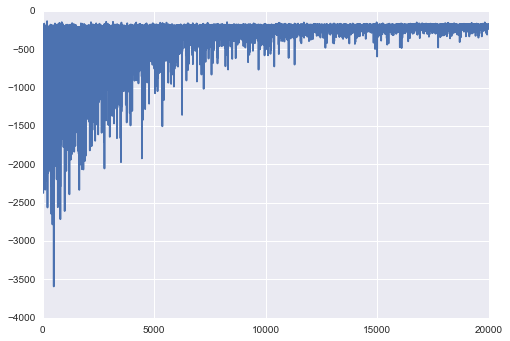

In [7]:
plt.plot(elbos)